# MLP

Split data into Train , val, test

In [1]:
from typing import List

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Small Data

In [10]:
# TEST DATASET
X, Y = get_ngrams(words=words[:4], ngrams=NGRAMS, debug=True)

-- emma --
... e
..e m
.em m
emm a
mma .
-- olivia --
... o
..o l
.ol i
oli v
liv i
ivi a
via .
-- ava --
... a
..a v
.av a
ava .
-- isabella --
... i
..i s
.is a
isa b
sab e
abe l
bel l
ell a
lla .


#### 2.1.2 Train Test split

In [11]:
# Split to 80 : 10 : 10 :: Train : Val : Test

def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]

split_data(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

([1, 2, 3, 4, 5, 6, 7, 8], [9, 0])

In [12]:
import random

# Shuffle words
random.shuffle(words)

In [13]:
train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [14]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182437, 3]), torch.Size([182437]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

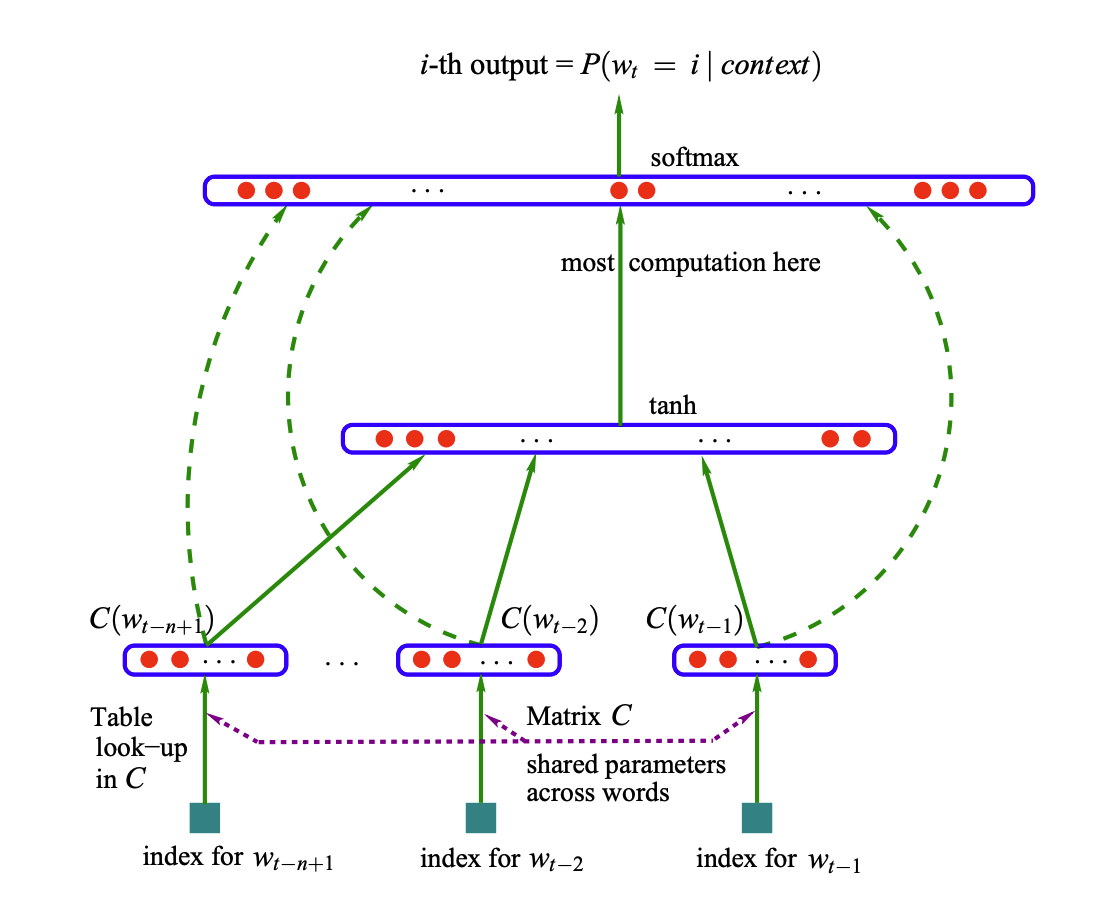

In [15]:
class MLP:
    
    def __init__(self, n_in, n_embed, n_positions, seed=4744):
        
        self._device = 'cpu'
        
        # Seed for reproducibility
        g = torch.Generator().manual_seed(seed)

        # Embeding Layer
        self.C = torch.randn((n_in, n_embed), generator=g)    

        # Hidden Layer
        self.W1 = torch.randn((CONTEXT_SIZE * n_embed, n_positions), generator=g)
        self.b1 = torch.randn((n_positions), generator=g)

        # Output Layer
        self.W2 = torch.randn((n_positions, n_in), generator=g)
        self.b2 = torch.randn((n_in), generator=g)

        # Parameters
        #self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        print(f"Number of Model Params: {sum(p.nelement() for p in self.parameters)}")

        # Require Grads , for backprop
        self.require_grads()

    @property
    def parameters(self):
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    @property
    def device(self):
        return self._device
    
    def require_grads(self):
        for p in self.parameters: p.requires_grad = True
            
    def __call__(self, x):
        
        # Forward call
        emb = self.C[x]                                                   # C(CHARS, N_EMBEDS) X[N, CONTEXT_SIZE] --> emb(N, CONTEXT_SIZE, N_EMBEDS)
        h = torch.tanh(emb.view(emb.shape[0], -1) @ self.W1 + self.b1)    # emb.view(N, CONTEXT_SIZE*N_EMBEDS) @ W1 + b1 --> (N, N_POSITIONS)
        logits = h @ self.W2 + self.b2                                    # --> logits(N, CHARS)
        return logits
  
    def to(self, device):
        if 'cuda' == device and not torch.cuda.is_available():
            print(f"Cuda not available")
            return
        
        self.C = self.C.detach().to(device)
        self.W1 = self.W1.detach().to(device)
        self.b1 = self.b1.detach().to(device)
        self.W2 = self.W2.detach().to(device)
        self.b2 = self.b2.detach().to(device)
            
        self._device = device
        self.require_grads()

### 3.2 Training Loop

In [16]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.losses = list()
        self.epochs = 0
    
    @staticmethod
    def get_batch_idxs(x, batch_size):
        return torch.randint(0, x.shape[0], size=(batch_size,))
        
    def train(self, x, y, batch_size=32, epochs=10, lrs=(0.1, 0.01), lr_decay_epoch=5):
        print(f"Dataset size: {len(x)}")
        epochs += self.epochs
        delta_epochs = epochs - self.epochs
        
        for epoch in tqdm(range(self.epochs, epochs), desc="Epochs"):
            # Batch indexes
            ix = self.get_batch_idxs(x, batch_size=batch_size)
            _x = x[ix].to(self.model.device)
            _y = y[ix].to(self.model.device)

            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {self.epochs} or epoch % int(delta_epochs/10) == int(delta_epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            for p in model.parameters: p.grad = None
            loss.backward()

            # Optimizer
            lr = lrs[0] if epoch < lr_decay_epoch else lrs[1]
            for p in model.parameters: p.data -= lr * p.grad
            
        self.epochs += delta_epochs
        return self.losses
    
    def evaluate(self, x, y):
        x = x.to(self.model.device)
        y = y.to(self.model.device)
        
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss

#### 3.6.1 Training

In [17]:
N_EMBED = 30
N_POSITIONS = 200

BATCH_SIZE = 128

In [18]:
# INIT MODEL
model = MLP(n_in=len(CHARS), n_embed=N_EMBED, n_positions=N_POSITIONS)

Number of Model Params: 24437


In [19]:
model.to("cuda")

In [20]:
trainer = Trainer(model=model)

Dataset size: 182437


Epochs:   0%|          | 0/200000 [00:00<?, ?it/s]

Loss 1/200000: 25.96472930908203
Loss 20000/200000: 2.262874126434326
Loss 40000/200000: 2.0505542755126953
Loss 60000/200000: 1.785648226737976
Loss 80000/200000: 2.1678738594055176
Loss 100000/200000: 1.958163857460022
Loss 120000/200000: 2.132568120956421
Loss 140000/200000: 1.938430905342102
Loss 160000/200000: 2.0102033615112305
Loss 180000/200000: 2.0479111671447754
Loss 200000/200000: 1.9771909713745117


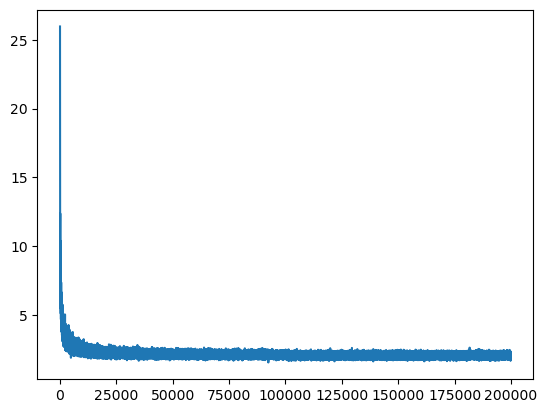

In [21]:
losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=200_000, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
plt.plot(losses)

Text(0, 0.5, 'log10(loss)')

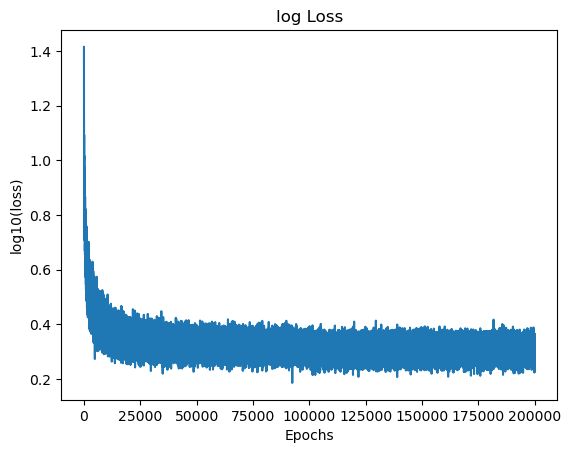

In [22]:
plt.plot(list(map(torch.log10, torch.tensor(losses)))); plt.title("log Loss"); plt.xlabel("Epochs"); plt.ylabel("log10(loss)")

In [23]:
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")
print(f"Test Loss: {trainer.evaluate(x=X_test, y=Y_test)}")

Train Loss: 2.0375967025756836
Val Loss: 2.1437220573425293
Test Loss: 2.155940294265747


## 4. Sampling : Name Generation

In [24]:
g = torch.Generator(device='cuda').manual_seed(4744)


def gen_word_nn(model):
    ix = 0
    context = [[stoi[START]] * CONTEXT_SIZE]
    new_word = ''
    while True:
        _x = torch.tensor(context).to(model.device)
        #_y = y[ix].to(self.model.device)

        # Forward
        logits = model(_x)
        probs = F.softmax(logits, dim=1)
        
        #_xenc = F.one_hot(torch.tensor([ix]), num_classes=len(CHARS)).float()
        #logits = _xenc @ W
        #counts = logits.exp()
        #probs = counts / counts.sum(dim=1, keepdims=True)
        
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = [context[0][1:] + [ix]]
        if ix == 0:
            break
        new_word += itos[ix]
    return new_word

gen_word_nn(model=model)

'syyskyler'

In [25]:
g = torch.Generator(device='cuda').manual_seed(4744)


new_words = list()

for _ in range(20):
    new_words.append(gen_word_nn(model=model))

new_words

['syyskyler',
 'salaieun',
 'zamyshauennesra',
 'sings',
 'liah',
 'sham',
 'har',
 'mus',
 'jahj',
 'tavire',
 'khyllahadley',
 'shadel',
 'greson',
 'zabella',
 'vydhira',
 'amandro',
 'aad',
 'lessamarver',
 'lian',
 'mais']